# Creating the Bathymetry

This notebook will create the bathymetry for the model.

## Bathymetry Source File

To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For this project, it will be using the entire planet and the bathymetry is named `GEBCO_2025_sub_ice.nc`.

## Libraries

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, label
from xarray import Dataset, open_dataset

## Directories

In [ ]:
PROJ_ROOT = Path("..").resolve()
DATA_DIR = PROJ_ROOT / "data"
INPUT_DIR = PROJ_ROOT / "input"

if not INPUT_DIR.exists():
    print(f"Creating directory: {INPUT_DIR}")
    INPUT_DIR.mkdir(parents=True, exist_ok=True)

## Files

In [ ]:
BATHY_FILE = DATA_DIR / "GEBCO_2025_sub_ice.nc"
OUTPUT_FILE = INPUT_DIR / "earth_bathymetry.bin"

## Parameters

In [2]:
DEL_X = 0.5
DEL_Y = 0.5
XG_ORIGIN = -180
YG_ORIGIN = -90
N_COLS = 720
N_ROWS = 360

## Target Grid Definition

Create the grid using Edge-to-Center method (`nb01_model_grid.ipynb`)

In [3]:
x_edges = np.linspace(XG_ORIGIN, XG_ORIGIN + N_COLS * DEL_X, N_COLS + 1)
y_edges = np.linspace(YG_ORIGIN, YG_ORIGIN + N_ROWS * DEL_Y, N_ROWS + 1)

xc = (x_edges[:-1] + x_edges[1:]) / 2
yc = (y_edges[:-1] + y_edges[1:]) / 2

# Create a xarray definition of your target
ds_target = Dataset(
    {
        "lat": (["lat"], yc),
        "lon": (["lon"], xc),
    }
)

print(f"Target Grid: {len(xc)}x{len(yc)}")

# Assertion to guarantee alignment with MITgcm parameters
assert len(xc) == N_COLS, f"Error: Expected {N_COLS} columns, got {len(xc)}"
assert len(yc) == N_ROWS, f"Error: Expected {N_ROWS} rows, got {len(yc)}"

Target Grid: 720x360


## Processing Bathymetry: Volume Conservation & Regridding

The bathymetry data is sourced from **GEBCO** (General Bathymetric Chart of the Oceans), which has a resolution of ~15 arc-seconds ($1/240^{\circ}$).

Since the model grid resolution is $0.5^{\circ}$ (coarse), direct interpolation would result in **aliasing errors** and a loss of physical volume (e.g., a single data point might land on a seamount peak, incorrectly representing the entire grid cell as shallow).

To address this, a two-step **"Bin-and-Map"** approach is used:

1.  **Coarsening (Block Averaging):** The high-resolution source data is averaged down to an intermediate resolution. This preserves the *mean depth* of the cell, ensuring volume conservation.
2.  **Interpolation:** The coarsened data is then linearly mapped onto the exact model coordinates.

In [4]:
COARSE_FACTOR = 60  # Downscaling factor (GEBCO 1/240 -> Model 1/2 = ~60x difference)

print(f"Lazy Loading GEBCO from {BATHY_FILE}...")
# Chunking allows us to work with the massive GEBCO file without loading it all into RAM
ds_source = open_dataset(BATHY_FILE, chunks={"lat": 2000, "lon": 2000})

# Standardize Variable Name (GEBCO usually uses 'elevation')
var_name = "elevation" if "elevation" in ds_source else "Depth"
bathy_da = ds_source[var_name]

# Standardize Sign Convention
# MITgcm usually expects negative values for ocean depth in Z-coordinates
# GEBCO 'elevation' is usually negative for ocean. We ensure it stays that way.
# If using 'Depth' (positive for ocean), you might need to flip this.
if bathy_da.mean() > 0:
    print("Detected positive depth convention. Flipping to negative (z-coordinate)...")
    bathy_da = -bathy_da

print("Step 1: Coarsening (Averaging) to preserve volume...")
# We average every N pixels to avoid aliasing.
# boundary='trim' handles edges if the division isn't perfect.
bathy_coarse = bathy_da.coarsen(
    lat=COARSE_FACTOR, lon=COARSE_FACTOR, boundary="trim"
).mean()

print("Step 2: Interpolating to Model Grid...")
# We use the 1D center coordinates (xc, yc) generated in the previous notebook cell
# method='linear' is sufficient now that the data is already smooth
bathy_interp = bathy_coarse.interp(lat=yc, lon=xc, method="linear")

# Extract the numpy array for the model
bathy_model = bathy_interp.values

# Quick sanity check on shapes
print(f"Regridding complete.")
print(f"Source Shape: {ds_source[var_name].shape}")
print(f"Target Shape: {bathy_model.shape} (Should be 360 x 720)")

Lazy Loading GEBCO from /home/jon/src/sjsu/cs185c-fall2024/project/data/GEBCO_2025_sub_ice.nc...
Step 1: Coarsening (Averaging) to preserve volume...
Step 2: Interpolating to Model Grid...
Regridding complete.
Source Shape: (43200, 86400)
Target Shape: (360, 720) (Should be 360 x 720)


## Physics Constraints & Smoothing

Raw bathymetry data often contains sharp spikes or extremely shallow regions that can cause numerical instability in ocean models. To ensure the model runs stably, the following corrections are applied:

1.  **Gaussian Smoothing:** A mild filter (`sigma=1.0`) is applied to smooth out sharp gradients, preventing "checkerboard" noise in the velocity fields.
2.  **Minimum Depth Enforcement:** Very shallow cells (e.g., < 5m) can restrict the time step required for stability (CFL condition). We enforce a minimum depth (e.g., 10m) and treat anything shallower as land ($0m$).

In [5]:
print("Applying Physics Constraints...")

# Fill NaNs
bathy_model = np.nan_to_num(bathy_model, nan=0.0)

# Gaussian Smoothing (Prevents numerical instability on steep slopes)
# Sigma=1.0 smooths over 1 grid cell.
bathy_model = gaussian_filter(bathy_model, sigma=1.0)

# Enforce Minimum Depth (hMin)
# MITgcm requires a minimum depth (usually ~10m) to avoid thin cells crashing the solver.
MIN_DEPTH = 10.0
# Set very shallow water to Land (0)
bathy_model[(bathy_model > -MIN_DEPTH) & (bathy_model < 0)] = 0
# Ensure land is exactly 0
bathy_model[bathy_model > 0] = 0

Applying Physics Constraints...


## Topological Cleaning: Removing Isolated Basins

Ocean models can crash if there are "puddles" or isolated lakes (like the Caspian Sea or small errors in the interpolation) that are not connected to the global ocean. These isolated regions cannot exchange mass or energy with the rest of the model, leading to drift.

The function below identifies all connected water bodies and:
1.  Finds the largest continuous body of water (The Global Ocean).
2.  Fills all smaller, isolated bodies of water with land ($0$).

In [6]:
def remove_isolated_cells(bathy):
    """
    Identifies connected water bodies. Keeps the largest one (Global Ocean).
    Fills all other isolated lakes/seas with 0 (Land).
    """
    print("Identifying isolated regions...")

    # 1. Define Water (1) and Land (0)
    wet_mask = bathy < 0

    # 2. Label connected components
    # structure defines connectivity (diagonal vs orthogonal)
    structure = np.ones((3, 3), dtype=int)
    labeled_array, num_features = label(wet_mask, structure=structure)

    if num_features < 2:
        print("No isolated regions found.")
        return bathy

    # 3. Find the Global Ocean
    # We assume the Global Ocean has the most grid points.
    region_counts = np.bincount(labeled_array.ravel())
    # Index 0 is land, so we look at index 1 onwards
    region_counts[0] = 0
    global_ocean_label = np.argmax(region_counts)

    print(
        f"Found {num_features} water bodies. Largest ID: {global_ocean_label} with {region_counts[global_ocean_label]} cells."
    )

    # 4. Create Clean Mask
    # True where it is the global ocean, False everywhere else (land or lakes)
    global_ocean_mask = labeled_array == global_ocean_label

    # 5. Apply Mask
    # Anything that was wet but is NOT the global ocean becomes land (0)
    bathy_cleaned = bathy.copy()
    # Mask out the isolated wet cells
    bathy_cleaned[wet_mask & ~global_ocean_mask] = 0

    return bathy_cleaned


# Apply the cleaning
bathy_model = remove_isolated_cells(bathy_model)

Identifying isolated regions...
Found 19 water bodies. Largest ID: 1 with 182148 cells.


## Final Visualization

Before saving, it is critical to visually verify the grid.
* **Left Plot:** Shows the full global bathymetry to ensure major features (trenches, ridges) are preserved.
* **Right Plot:** Zooms in on the "coastline" (0m to -1m) to verify that the land masking and minimum depth cleaning worked correctly.

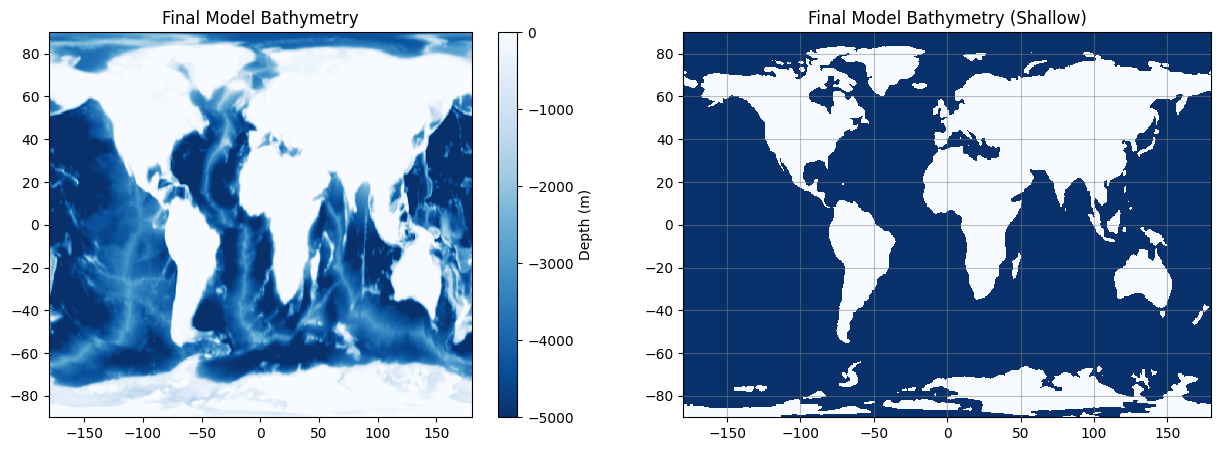

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(xc, yc, bathy_model, cmap="Blues_r", vmin=-5000, vmax=0)
plt.title("Final Model Bathymetry")
plt.colorbar(label="Depth (m)")

plt.subplot(1, 2, 2)
plt.pcolormesh(xc, yc, bathy_model, cmap="Blues_r", vmin=-1, vmax=0)
plt.title("Final Model Bathymetry (Shallow)")
plt.grid(True, color="gray", alpha=0.5)
plt.show()

## Exporting for MITgcm

Finally, the bathymetry is saved as a raw binary file (`.bin`) required by MITgcm.

* **Data Layout:** The array is flattened in "C" order (row-major).
* **Precision:** Converted to **Big Endian 32-bit Float** (`>f4`), which is the standard format for MITgcm binary input files.
* **Transpose Check:** MITgcm expects dimensions $(N_x, N_y)$. Since Python/Xarray works in $(Lat, Lon)$, the array is transposed if necessary.

In [8]:
print(f"Saving binary to {OUTPUT_FILE}...")

# Check shape. MITgcm usually expects (Nx, Ny) aka (720, 360).
# If your bathy_model is (360, 720) from Xarray (Lat, Lon), you must TRANSPOSE it.
if bathy_model.shape == (N_ROWS, N_COLS):
    print("Transposing bathymetry from (Lat, Lon) to (Lon, Lat) for MITgcm...")
    bathy_model = bathy_model.T

print(f"Final Shape for Binary: {bathy_model.shape}")  # Should be (720, 360)

# Ensure Big Endian Float32 for MITgcm
bathy_model.ravel("C").astype(">f4").tofile(str(OUTPUT_FILE))
print(f"Done. File saved to {OUTPUT_FILE}")

Saving binary to /home/jon/src/sjsu/cs185c-fall2024/project/input/earth_bathymetry.bin...
Transposing bathymetry from (Lat, Lon) to (Lon, Lat) for MITgcm...
Final Shape for Binary: (720, 360)
Done. File saved to /home/jon/src/sjsu/cs185c-fall2024/project/input/earth_bathymetry.bin
